# From the address to the 3D

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy as gp
import folium
import geopandas as gpd
from shapely.geometry import Point
import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

In [2]:
from functions import *

## Enter an address, get a location

In [3]:
# Google API (quand compte ok)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.geocoders.GoogleV3(api_key='')
    location = locator.geocode(address, timeout=10)
    print(location.raw)
    print(location.address)
    postcode = location.address['postcode']
    country_code = location.address['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
Gare de Ottignies


<ipython-input-3-f8019876c1a0>:8: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  locator = gp.geocoders.GoogleV3(api_key='')


GeocoderQueryError: Your request was denied.

In [85]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
Gare de Namur
Latitude = 4.862421313946799, Longitude = 50.469100100000006, Postcode = 5000


In [86]:
mappy = folium.Map(
    location=[coord[0],coord[1]],
    zoom_start=17
)

folium.CircleMarker(
    location=[coord[0],coord[1]],
    radius=30,
    popup='Your address',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(mappy)

mappy

## Get the corrects LiDAR files' path

In [87]:
path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        pass
    flanders = True
    print('Brussels or Flanders region')

Namur


## From coordinates to correct crs

In [88]:
# Walloon region uses EPSG:31370
# Flanders region uses EPSG:?

if flanders == False:
    p = gpd.GeoSeries([Point(coord[1], coord[0])])
    p.crs = 'epsg:4326'
    p = p.to_crs(epsg=31370)
    print(p[0])
else:
    pass



C:\Users\morga\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


POINT (185046.4410823517 128813.7578461301)


## Get a sample of the LiDARs, center on the coordinates

##### DSM

D:/Resources/Wallonia/DSM 2013-2014/RELIEF_WALLONIE_MNS_2013_2014_GEOTIFF_31370_PROV_NAMUR/RELIEF_WALLONIE_MNS_2013_2014.tif
Pixel Y, X coords: 21186, 41046


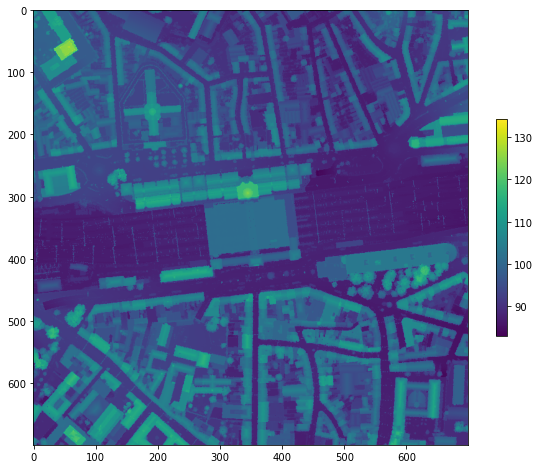

In [89]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

print(path_dsm)

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)

plt.figure(figsize=(10, 8))
plt.imshow(small_dsm)
plt.colorbar(shrink=0.5)
plt.show()

##### DTM

Pixel Y, X coords: 40911, 77819


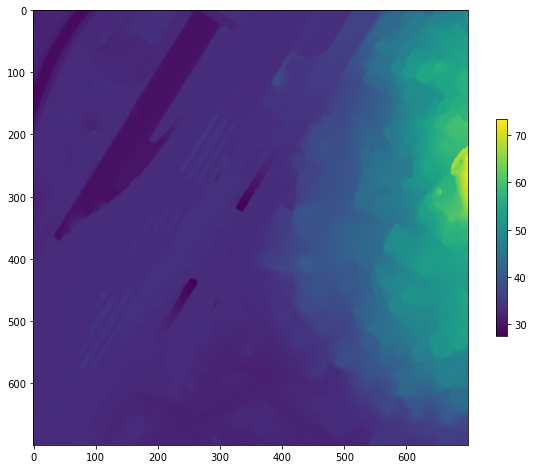

In [83]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)

plt.figure(figsize=(10, 8))
plt.imshow(small_dtm)
plt.colorbar(shrink=0.5)
plt.show()

## Get the Canopy Height Model

DSM - DTM = CHM

TO DO :
    
Flandre :
    "Get the file"
    analyser shapefile pour obtenir coordonnées min/max
    selectionner les bons fichiers
    avoir le système de référence (crs)
    transformer coord das le système de référence
    
Les deux :
    "get canopy"
    Soustraire les deux datasets
    Projection 3D
    